In [1]:
# 0. Imports & setup

import torch
from pathlib import Path
from IPython.display import display

from models.SanaSprintOneStep import SanaTransformerOneStepES  # same wrapper as in training
from peft import PeftModel

torch.set_float32_matmul_precision("high")  # optional

DEVICE = "cuda:0" if torch.cuda.is_available() else "mps"
MODEL_NAME = "Efficient-Large-Model/Sana_Sprint_1.6B_1024px_diffusers"

SAVE_DIR = Path("es_runs_eggroll_pickscore_multiprompt")
BEST_LORA_DIR = SAVE_DIR / "best_lora"          # created by train script
ENCODED_PROMPT_PATH = Path("encoded_prompts_multi_test.pt")

In [2]:
# 1. Load encoded prompts

print(f"[init] loading encoded prompts from {ENCODED_PROMPT_PATH}...")
prompt_data = torch.load(ENCODED_PROMPT_PATH, map_location="cpu")

prompt_embeds_all = prompt_data["prompt_embeds"]           # [P, seq, dim]
attention_mask_all = prompt_data["prompt_attention_mask"]  # [P, seq]
prompts_list = prompt_data.get("prompts", None)

num_prompts = prompt_embeds_all.shape[0]
print(f"num_prompts: {num_prompts}")
if prompts_list is not None:
    for i, p in enumerate(prompts_list):
        print(f" [{i:02d}] {p}")

[init] loading encoded prompts from encoded_prompts_multi_test.pt...
num_prompts: 8
 [00] Will Smith eating an egg roll on a neon-lit street in Tokyo at night, cinematic, shallow depth of field, 35mm photography
 [01] A hyper-realistic portrait of an elderly woman with deep wrinkles, soft window light, 85mm photography, shallow depth of field
 [02] A futuristic Tokyo street at night in the rain, glowing neon signs reflected on wet pavement, cinematic wide shot”
 [03] A small orange cat wearing a spacesuit, floating inside a spaceship cockpit, digital art, Pixar style
 [04] An ancient library filled with towering bookshelves and warm candlelight, ultra-detailed, concept art
 [05] A surreal desert landscape with giant glass spheres hovering above the sand, sunset, 8k, artstation trending
 [06] A bowl of ramen on a wooden table, steam rising, food photography, overhead shot, natural light
 [07] An isometric illustration of a cozy apartment with a computer desk, plants, and a sleeping dog,

In [3]:
# 2. Create two Sana ES wrappers: base and LoRA

print("[init] loading BASE SanaSprintOneStepES...")
sana_base = SanaTransformerOneStepES(
    model_name=MODEL_NAME,
    device=DEVICE,
    DTYPE=torch.float16,
    sigma_data=0.5,
)
sana_base.transformer.to(DEVICE).eval()

print("[init] loading LORA SanaSprintOneStepES...")
sana_lora = SanaTransformerOneStepES(
    model_name=MODEL_NAME,
    device=DEVICE,
    DTYPE=torch.float16,
    sigma_data=0.5,
)
sana_lora.transformer.to(DEVICE).eval()

print(f"[init] loading LoRA adapter from {BEST_LORA_DIR} ...")
# This will read the adapter config + weights saved by `save_pretrained(best_lora_dir)`
sana_lora.transformer = PeftModel.from_pretrained(
    sana_lora.transformer,
    BEST_LORA_DIR,
)
sana_lora.transformer.to(DEVICE).eval()

print("Models ready:")
print("  base:", type(sana_base.transformer))
print("  lora:", type(sana_lora.transformer))

[init] loading BASE SanaSprintOneStepES...
[init] loading LORA SanaSprintOneStepES...
[init] loading LoRA adapter from es_runs_eggroll_pickscore_multiprompt/best_lora ...
Models ready:
  base: <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>
  lora: <class 'peft.peft_model.PeftModel'>


In [4]:
# 3. Generation helper

@torch.no_grad()
def generate_with_es_lora(
    prompt_idx: int = 0,
    num_images: int = 1,
    guidance_scale: float = 4.5,
    width_latent: int = 32,
    height_latent: int = 32,
    seed: int = 0,
    mode: str = "both",   # "base", "lora", or "both"
):
    """
    Generate images for a given encoded prompt using:
        - mode="base": base model only
        - mode="lora": ES-trained LoRA model only
        - mode="both": both, with same seed (for as fair a comparison as possible)

    Returns:
        if mode in {"base", "lora"}:
            list[PIL.Image]
        if mode == "both":
            {"base": list[PIL.Image], "lora": list[PIL.Image]}
    """
    assert 0 <= prompt_idx < num_prompts, "prompt_idx out of range"
    assert mode in ("base", "lora", "both")

    prompt_embeds = prompt_embeds_all[prompt_idx : prompt_idx + 1].to(DEVICE)
    attn_mask = attention_mask_all[prompt_idx : prompt_idx + 1].to(DEVICE)

    if num_images > 1:
        prompt_embeds = prompt_embeds.expand(num_images, -1, -1).contiguous()
        attn_mask = attn_mask.expand(num_images, -1).contiguous()

    def _run(model_wrapper, seed_value: int):
        images, _latents = model_wrapper.sana_one_step_trigflow(
            prompt_embeds=prompt_embeds,
            prompt_attention_mask=attn_mask,
            latents=None,
            seed=seed_value,
            guidance_scale=guidance_scale,
            width_latent=width_latent,
            height_latent=height_latent,
        )
        return images

    imgs_base = imgs_lora = None

    if mode in ("base", "both"):
        imgs_base = _run(sana_base, seed)

    if mode in ("lora", "both"):
        imgs_lora = _run(sana_lora, seed)

    if mode == "base":
        return imgs_base
    elif mode == "lora":
        return imgs_lora
    else:
        return {"base": imgs_base, "lora": imgs_lora}

Comparing BASE vs LoRA for prompt index 3
Prompt: A small orange cat wearing a spacesuit, floating inside a spaceship cockpit, digital art, Pixar style

=== Sample 0 ===
Base:


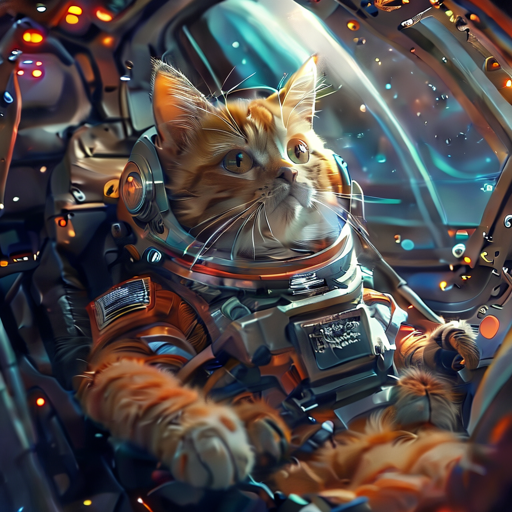

LoRA:


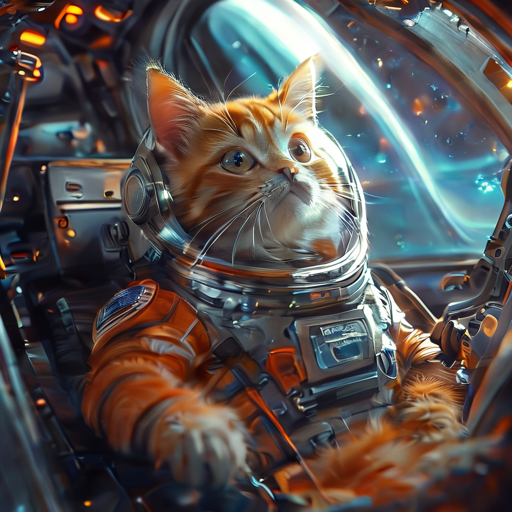

In [42]:
# 4. Example: compare base vs LoRA for one prompt

prompt_idx = 3  # change to whatever you want
num_images = 1
guidance_scale = 4.5
seed = 3321111231

print(f"Comparing BASE vs LoRA for prompt index {prompt_idx}")
if prompts_list is not None:
    print("Prompt:", prompts_list[prompt_idx])

outs = generate_with_es_lora(
    prompt_idx=prompt_idx,
    num_images=num_images,
    guidance_scale=guidance_scale,
    seed=seed,
    mode="both",
)

imgs_base = outs["base"]
imgs_lora = outs["lora"]

for i in range(num_images):
    print(f"\n=== Sample {i} ===")
    print("Base:")
    display(imgs_base[i].resize((512,512)))
    print("LoRA:")
    display(imgs_lora[i].resize((512,512)))